# Multi-label Patent Classification with Neural Networks

In [139]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Input, Embedding, Bidirectional, Reshape, Flatten, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D, SpatialDropout1D
from keras.layers import concatenate
from keras.preprocessing import text, sequence
from keras import utils
from keras import callbacks
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics

import nltk
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [2]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

# file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
# file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})

In [3]:
# labels 
# label_names = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
# label_names = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClassCode.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [4]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,9)] # renaming columns 

print(X.shape)
print(Y.shape)

(78372, 4)
(78372, 8)


In [5]:
X.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHICLE,The system finds application with the motor ve...,CLAIMS 1. Integral multifunctional system for ...,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHI...
0000002,TURBINE DRIVEN WITH A FLUID MEDIUM,Turbine driven by a flowing medium to generate...,Claims 1. Turbine driven by a flowing medium t...,TURBINE DRIVEN WITH A FLUID MEDIUM. Technical ...
0000003,METHOD TO REMOVE LEAKAGE PROBLEMS IN PIPES PRO...,Method to remove leakage problems in pipes pro...,CLAIMS Claim 1 ) A new method in which choke a...,SPECIFICATION METHOD TO REMOVE LEAKAGE PROBLEM...
0000004,PRESSURE RELEASE VALVE,A pressure release valve is disclosed ideally ...,CLAIMS 1. A pressure release valve comprising ...,Pressure Release Valve This invention relates ...
0000005,ROLL-OVER MECHANISM FOR A PRESSURE RELEASE VALVE,A rollover mechanism for a pressure valve is d...,"CLAIMS 1. A roll-over mechanism for a valve, s...",Roll-over mechanism for a pressure release val...


In [6]:
Y.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,F02B,None,None,None,None,None,None,None
0000002,F03D,F03B,None,None,None,None,None,None
0000003,F16L,None,None,None,None,None,None,None
0000004,F16K,None,None,None,None,None,None,None
0000005,F16K,None,None,None,None,None,None,None


In [7]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [8]:
print(X_clean.shape)
print(Y_clean.shape)

(78372, 4)
(78372, 8)


In [9]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...


In [10]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,f02b,None,None,None,None,None,None,None
0000002,f03d,f03b,None,None,None,None,None,None
0000003,f16l,None,None,None,None,None,None,None
0000004,f16k,None,None,None,None,None,None,None
0000005,f16k,None,None,None,None,None,None,None


In [11]:
# Creating dataset 
data = pd.DataFrame()
data = X_clean

# concat the text of all patent sections and join the labels
#data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [14]:
data.head()

,title,abstract,claim,desc,label1,labels
doc_num,,,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...,f02b,[f02b]
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...,f03d,"[f03d, f03b]"
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...,f16l,[f16l]
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...,f16k,[f16k]
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...,f16k,[f16k]


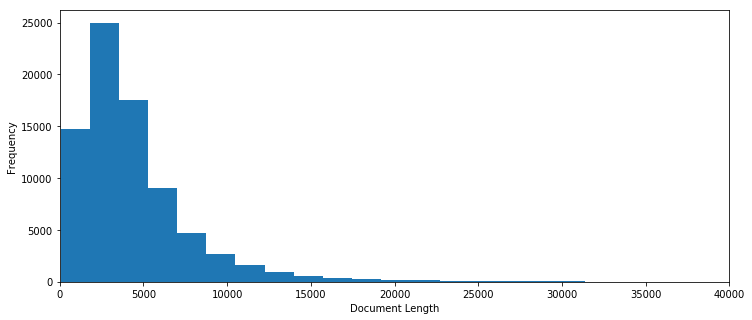

In [14]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts, bins=100)
plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,40000], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts)

In [15]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 4433 words
Median document length: 3488.0 words
Max document length: 174233 words
Min document length: 48 words


In [16]:
# average number of labels per document 
print("Avg. number of labels in dataset: {}".format(data['labels'].apply(lambda x: len(x)).mean()))

Avg. number of labels in dataset: 1.394949726943296


### Encoding Labels with MultiLabelBinarizer

In [15]:
data['labels'].head()

doc_num
0000001          [f02b]
0000002    [f03d, f03b]
0000003          [f16l]
0000004          [f16k]
0000005          [f16k]
Name: labels, dtype: object

In [12]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [13]:
# labels_df.iloc[:,[538]].sum()   #470

In [14]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

,f01b,f01c,f01d,f01k,f01l,f01m,f01n,f01p,f02b,f02c,...,f41a,f41b,f41c,f41f,f41g,f41h,f41j,f42b,f42c,f42d
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print("We have {} classes".format(len(mlb.classes_)))


We have 96 classes


### Advanced text processing and TF_IDF 
The following processing was applied to `data['full_text']`:

- removing punctuation 
- lowercasing (happened earlier no need to do it here)
- ** Detect and Remove non-english documents - TO DO **
- removing stop words 
- romoving common / rare words (did not run this)
- lemmatization or stemming (we chose lemmatization)
- remove digits
- filtering 600 best words in each document based on tf_idf algorithm 

In [41]:
data['full_text'].head(10)

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium claims 1. t...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve claims 1. a pressure re...
0000005    roll-over mechanism for a pressure release val...
0000007    device by ball valve c l a i m s 1. a valve, i...
0000008    composite electroconducting material claims 1....
0000009    process and apparatus for agglomeration of pow...
0000011    heating unit for rock material claims 1. a hea...
0000012    a method and apparatus for microwave processin...
Name: full_text, dtype: object

### 1. Advanced Processing

In [15]:
# removing punctuation 
import re, string, timeit

regex = re.compile('[%s]' % re.escape(string.punctuation), re.MULTILINE)


data['title'] = data['title'].apply(lambda x : regex.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : regex.sub("", x))
data['claim'] = data['claim'].apply(lambda x : regex.sub("", x))
data['desc'] = data['desc'].apply(lambda x : regex.sub("", x))





#data['full_text_proc'] = data['full_text'].str.replace('[^\w\s]','')
#data['full_text_proc'].head(10)

In [17]:
# remove whitespace
r = re.compile(r"^\s+", re.MULTILINE)
data['title'] = data['title'].apply(lambda x : r.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r.sub("", x))

In [18]:
# Convert to lower - casing 

data['title'] = data['title'].apply(lambda x : x.lower())
data['abstract'] = data['abstract'].apply(lambda x : x.lower())
data['claim'] = data['claim'].apply(lambda x : x.lower())
data['desc'] = data['desc'].apply(lambda x : x.lower())

#data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [19]:
# Remove URLs

re_url = re.compile(r'^http\S+', re.MULTILINE|re.UNICODE)

data['title'] = data['title'].apply(lambda x : re_url.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : re_url.sub("", x))
data['claim'] = data['claim'].apply(lambda x : re_url.sub("", x))
data['desc'] = data['desc'].apply(lambda x : re_url.sub("", x))


In [20]:
# Remove text that has claim and a number

r1 = re.compile(r'(?:claim\S\d+|claim\S \d+|claim \d+|claims?)', re.MULTILINE|re.UNICODE)


data['title'] = data['title'].apply(lambda x : r1.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r1.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r1.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r1.sub("", x))


In [21]:
# Introduce space on either side of new line

r2 = re.compile(r'.\n', re.MULTILINE|re.UNICODE)

data['title'] = data['title'].apply(lambda x : r2.sub(" \n ", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub(" \n ", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub(" \n ", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub(" \n ", x))

In [22]:
# remove temperature data such as 105°

r2 = re.compile(r"\d+°?", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [24]:
# remove special characters \xad

r2 = re.compile(r"\xad", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [25]:
#Remove special characters - '', and ¬,

data['title'] = data['title'].str.replace('\'','')
data['abstract'] = data['abstract'].str.replace('\'','')
data['claim'] = data['claim'].str.replace('\'','')
data['desc'] = data['desc'].str.replace('\'','')

data['title'] = data['title'].str.replace('¬','')
data['abstract'] = data['abstract'].str.replace('¬','')
data['claim'] = data['claim'].str.replace('¬','')
data['desc'] = data['desc'].str.replace('¬','')


In [46]:
# Remove special characters "' and ¬"

r2 = re.compile(r"[']", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

r2 = re.compile(r"[¬]", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [47]:
# Remove dots from the data

r2 = re.compile(r"[.]", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [48]:
# Merge all the four sections

data['full_text1'] = X_clean['title'] + " \n " + X_clean['claim'] + " \n " + X_clean['abstract'] + " \n " + X_clean['desc']


data['full_text1'].head()

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium \n  turbine...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve \n  a pressure release ...
0000005    rollover mechanism for a pressure release valv...
Name: full_text1, dtype: object

## Use Keras tokenizer to create sequences / tokens of the text

In [52]:
token = text.Tokenizer(filters='.°™\'¯⊘■®') # num_words=sequence_length lower=True
#d_text = ['The blue sky is blue and orange\n The world is new','black and blue new color']
token.fit_on_texts(data['full_text1'])
word_index = token.word_index
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 581702


In [54]:
# convert the full text to sequences and then back to text.
# This helps in getting the cleaned text after applying filters that used in the keras tokenizer
data_full_text_seq = token.texts_to_sequences(data['full_text1'])
data_full_text_txt = token.sequences_to_texts(data_full_text_seq)



## Create Word embeddings using CBOW (Word2vec)

### Create input text for the word embedding algorithm

In [56]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import re
from tqdm import tqdm
vocab = Counter()
tokenizer_word = WordPunctTokenizer()


def text_to_wordlist(text):
    
   # Tokenize
    text = tokenizer_word.tokenize(text)
    
   # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text)
        comments.append(txt)
    return comments
CBOW_input_full_text = process_comments(data_full_text_txt)

100%|██████████| 78372/78372 [07:19<00:00, 178.30it/s]


### Gensim Word2Vec - CBOW Model

In [59]:
import datetime
from gensim.models import Word2Vec

print(datetime.datetime.now())
model1 = Word2Vec(CBOW_input_full_text, size=100, window=5, min_count=0, workers=16, sg=0)
word_vectors1 = model1.wv
print(datetime.datetime.now())
print("Number of word vectors: {}".format(len(word_vectors1.vocab)))

2018-08-07 16:12:21.357433
2018-08-07 16:40:30.565568
Number of word vectors: 572817


In [60]:
model1.save("word2vec_cbow.model")

### Create embedding matrix

In [66]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in vocab:    
        embedding_vector = word_vectors1[word]
    else:
        embedding_vector = None
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [256]:
embedding_matrix.shape

(581703, 100)

## TF IDF Methodology to extract important words

In [85]:
# Initialize a TFIDF Vecxtorizer and pass the preprocessed full text

from sklearn.feature_extraction.text import TfidfVectorizer



tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
                        stop_words='english', ngram_range=(1,1)) 

text_transformed = tfidf.fit_transform(data['full_text1'])


In [105]:
# Transform the data for title, claim, abstract and description using TFIDF model 
# store the TFIDF values for the words for each of the sections

title_tfidf =  tfidf.transform(data['title'])
claim_tfidf =  tfidf.transform(data['claim'])
abstract_tfidf =  tfidf.transform(data['abstract'])
desc_tfidf =  tfidf.transform(data['desc'])

In [109]:
# Initialize dataframes to store top words based on TF IDF for each of the sections.
col_names =  ['i','top_words']
max_length = 150
title_top_words  = pd.DataFrame(columns = col_names)
claim_top_words  = pd.DataFrame(columns = col_names)
abstract_top_words  = pd.DataFrame(columns = col_names)
desc_top_words  = pd.DataFrame(columns = col_names)

### Get top words for Title using TFIDF

In [110]:

feature_names = np.array(tfidf.get_feature_names())

for i in tqdm(range(text_transformed.shape[0])):
    f_index = title_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[title_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    title_top_words.loc[len(title_top_words)] = [i,txt]
    
    
    





100%|██████████| 78372/78372 [14:18<00:00, 91.25it/s] 


In [111]:
title_top_words.head()

,i,top_words
0,0,multifunctional integral vehicle motor
1,1,turbine medium driven fluid
2,2,plasticbase pipes leakage remove materials pro...
3,3,release valve pressure
4,4,rollover release mechanism valve pressure


### Get top words for claim using TFIDF

In [114]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = claim_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[claim_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    claim_top_words.loc[len(claim_top_words)] = [i,txt]

100%|██████████| 78372/78372 [21:07<00:00, 61.84it/s] 


### Get top words for description using TFIDF

In [115]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = desc_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[desc_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    desc_top_words.loc[len(desc_top_words)] = [i,txt]

  0%|          | 7/78372 [00:00<21:58, 59.44it/s]

150


100%|██████████| 78372/78372 [34:24<00:00, 37.96it/s]


In [116]:
claim_top_words.head()

,i,top_words
0,0,hydraulic multifunctional connected accumulato...
1,1,foil turbine characterised longitual foils dis...
2,2,muff clampcoupling clampsystem choke latch mal...
3,3,valve magnetic characterised attraction plunge...
4,4,pendulum characterised means rollover tanker m...


In [117]:
desc_top_words.head()

,i,top_words
0,0,hydraulic accumulator liquid machine engine mi...
1,1,foils foil turbine longitual discoidal angel s...
2,2,muff plasticbase pipes gasket clampcoupling ch...
3,3,tanker rollover valve plunger petrol pressure ...
4,4,tanker rollover petrol float valve pendulum me...


### Get top words for abstract using TFIDF

In [118]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = abstract_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[abstract_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    abstract_top_words.loc[len(abstract_top_words)] = [i,txt]

100%|██████████| 78372/78372 [18:45<00:00, 69.63it/s] 


##  Create new datatable to store the top 150 words from each of the 4 sections

In [124]:
title_top_words.columns = ['title_no','title']
abstract_top_words.columns = ['abstract_no','abstract']
desc_top_words.columns = ['desc_no','desc']
claim_top_words.columns = ['claim_no','claim']


Data_Final = pd.concat([title_top_words['title'], 
           abstract_top_words['abstract'], 
           claim_top_words['claim'], 
           desc_top_words['desc']], axis=1).sort_index() 

Data_Final.head()

,title,abstract,claim,desc
0,multifunctional integral vehicle motor,hydraulic accumulator engine auxiliary microco...,hydraulic multifunctional connected accumulato...,hydraulic accumulator liquid machine engine mi...
1,turbine medium driven fluid,foil foils abolute connectec shaft discoidal f...,foil turbine characterised longitual foils dis...,foils foil turbine longitual discoidal angel s...
2,plasticbase pipes leakage remove materials pro...,plasticbase muff clampsystem tightcoupling but...,muff clampcoupling clampsystem choke latch mal...,muff plasticbase pipes gasket clampcoupling ch...
3,release valve pressure,rollover tanker valve plunger attraction magne...,valve magnetic characterised attraction plunge...,tanker rollover valve plunger petrol pressure ...
4,rollover release mechanism valve pressure,rollover tanker valve tankers pendulous seat f...,pendulum characterised means rollover tanker m...,tanker rollover petrol float valve pendulum me...


## Test Train split

In [125]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(Data_Final, labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(62697, 4)
(15675, 4)
(62697, 96)
(15675, 96)


## Padding train and test data and converting them to sequences

In [126]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
sequence_length = 150

# Create Input matricx for the four sections for train and test

X_train_title_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['title']), maxlen=sequence_length)
X_train_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['claim']), maxlen=sequence_length)

X_train_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['desc']), maxlen=sequence_length)

X_train_abstract_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['abstract']), maxlen=sequence_length)



X_test_title_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['title']), maxlen=sequence_length)
X_test_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['claim']), maxlen=sequence_length)

X_test_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['desc']), maxlen=sequence_length)

X_test_abstract_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['abstract']), maxlen=sequence_length)



print(X_train_claim_seq.shape)
print(X_test_claim_seq.shape)

(62697, 150)
(15675, 150)


## Hyper parameters for CNN - BILSTM Model

In [165]:
vocabulary_size = embedding_matrix.shape[0]
sequence_length = sequence_length
embedding_dim = embedding_matrix.shape[1]
num_filters = 128
kernel_size = 3
pool_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 128

learning_rate = 0.001

# Define Training Parameters 
batch_size = 100
epochs = 20



## CNN - BILSTM Model

In [166]:
def CNN_BiLSTM_model():
    
    # Title Channel
    
    # Input Layer
    input_layer1 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer1 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer1) # embedding_matrix
    #embedding_layer = SpatialDropout1D(0.2)(embedding_layer)
    #embedding_layer = Dropout(0.2)(embedding_layer)

    # Convolutional Layer
    conv_layer1 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer1)

    # The paper doesn't include a pooling layer !!!
    # Pooling Layer
    #pooling_layer = GlobalMaxPool1D()(conv_layer)
    #pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) #default pool size is 2

    # Claim Channel
    
    # Input Layer
    input_layer2 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer2 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer2) # embedding_matrix

    # Convolutional Layer
    conv_layer2 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer2)
    
    # abstract Channel
    
    # Input Layer
    input_layer3 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer3 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer3) # embedding_matrix

    # Convolutional Layer
    conv_layer3 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer3)   
    
    # desc Channel
    
    # Input Layer
    input_layer4 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer4 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer4) # embedding_matrix

    # Convolutional Layer
    conv_layer4 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer4)      
    
    #concatenation
    merged_concat = concatenate([conv_layer1, conv_layer2, conv_layer3,conv_layer4],axis=1)
    
    #Maximum
    #merged_max = maximum([conv_layer1, conv_layer2, conv_layer3,conv_layer4])
    
    #Average
    #merged_avg = average([conv_layer1, conv_layer2, conv_layer3,conv_layer4])
    
    #Summation
    #merged_sum = add([conv_layer1, conv_layer2, conv_layer3,conv_layer4])

    
    
    # bi-LSTM layer1
    bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_concat)
    
     # bi-LSTM layer2
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_max)
    
     # bi-LSTM layer3
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_avg)
    
     # bi-LSTM layer4
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_sum)

    # Output layer
    # output_layer1 = Dense(50, activation="relu")(pooling_layer)
    #output_layer1 = Dropout(0.25)(bilstm_layer)
    #output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1)
    output_layer1 = Dense(units=units, activation="sigmoid")(bilstm_layer1)

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal
    # is to treat each output labels as an independent Bernoulli distribution
    model = models.Model(inputs=[input_layer1,input_layer2,input_layer3,input_layer4], outputs=output_layer1,)
   
    model.compile(optimizer=optimizers.Adam(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model

In [168]:
# Choosing Model 
model = CNN_BiLSTM_model() 

In [169]:
# Training CNN-BiLSTM with our own embeddings 
history = model.fit([X_train_title_seq,X_train_claim_seq,X_train_abstract_seq,X_train_desc_seq], Y_train,  # class_weight=class_weight_dict,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)

Train on 56427 samples, validate on 6270 samples
Epoch 1/20
56427/56427 [==============================] - 849s 15ms/step - loss: 0.0762 - acc: 0.9831 - val_loss: 0.0600 - val_acc: 0.9856
Epoch 2/20
56427/56427 [==============================] - 836s 15ms/step - loss: 0.0537 - acc: 0.9857 - val_loss: 0.0464 - val_acc: 0.9865
Epoch 3/20
56427/56427 [==============================] - 835s 15ms/step - loss: 0.0423 - acc: 0.9873 - val_loss: 0.0386 - val_acc: 0.9883
Epoch 4/20
56427/56427 [==============================] - 839s 15ms/step - loss: 0.0363 - acc: 0.9888 - val_loss: 0.0354 - val_acc: 0.9890
Epoch 5/20
56427/56427 [==============================] - 839s 15ms/step - loss: 0.0329 - acc: 0.9897 - val_loss: 0.0333 - val_acc: 0.9897
Epoch 6/20
56427/56427 [==============================] - 841s 15ms/step - loss: 0.0303 - acc: 0.9905 - val_loss: 0.0320 - val_acc: 0.9901
Epoch 7/20
56427/56427 [==============================] - 842s 15ms/step - loss: 0.0284 - acc: 0.9909 - val_loss: 0.0

### Evaluation Metrics

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

## Evaluation

In [170]:
def get_pred_classes(X_test_seq, number_of_labels = 1):

    preds = np.zeros(shape=model.predict(X_test_seq).shape)
    pred_proba = model.predict(X_test_seq)

    for i in range(pred_proba.shape[0]): 
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_labels]
        preds[i][idxs] = 1
    
    return preds

### CNN+BiLSTM Model Results with our trained word2vec embeddings

#### Top 1 label prediction

In [171]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.719170653907496
recall: 0.5920931875142402
f1: 0.6302160451634136


#### Top 2 labels prediction

In [172]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.4767145135566188
recall: 0.736738057264373
f1: 0.5570777954988482


#### Top 10 labels prediction

In [173]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.12815948963317386
recall: 0.9296799574694312
f1: 0.2199084980337443


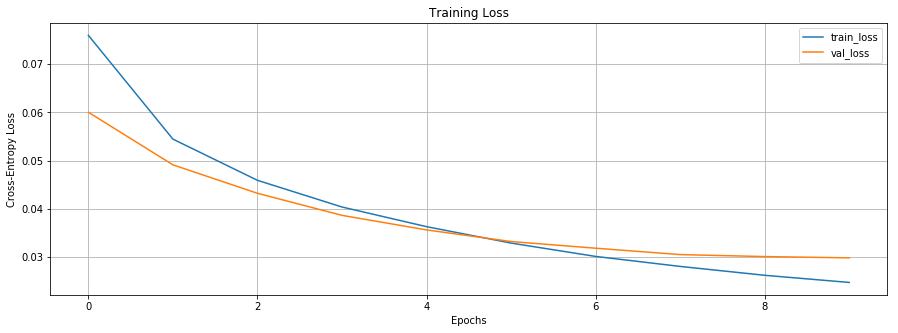

In [160]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.grid()
plt.ylabel("Cross-Entropy Loss")
plt.legend(loc="upper right")

### Error Analysis

In [163]:
def get_df_with_results(labels=1):
    pred_proba = model.predict([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq])
    all_labels = mlb.classes_
    pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = labels)

    # Getting the predicted and actual labels in each patent in the test set
    predicted_labels = [all_labels[np.argsort(pred_proba[i])[::-1][:labels]] for i in range(pred_proba.shape[0])]
    actual_labels = [list(mlb.inverse_transform(Y_test)[i]) for i in range(pred_proba.shape[0])]

    # Getting the individual precisions and recalls
    precisions = [metrics.precision_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]
    recalls = [metrics.recall_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]
    
    # Creating a dataframe with all the results
    df_with_results = pd.DataFrame({'predicted_labels':predicted_labels,
                                  'actual_labels':actual_labels, 
                                  'precision':precisions, 
                                  'recall':recalls}, columns = ['predicted_labels','actual_labels','precision','recall'])
    
    return df_with_results


def calculate_total_scores(df_with_results):
    total_prec = round(df_with_results.precision.mean(),3)
    total_recall = round(df_with_results.recall.mean(),3)
    total_f1 = round(2*(total_prec*total_recall)/(total_prec+total_recall),3)
    return print("Precision: {}, Recall: {}, F1-score: {}".format(total_prec, total_recall, total_f1))

### CNN + BiLSTM

### Top 1 Label - Precision, Recall and F1-score

In [257]:
df_with_results = get_df_with_results(labels=1)
calculate_total_scores(df_with_results)

Precision: 0.719, Recall: 0.592, F1-score: 0.649


### Top 5 Label - Precision, Recall and F1-score

In [174]:
df_with_results = get_df_with_results(labels=5)
calculate_total_scores(df_with_results)

Precision: 0.236, Recall: 0.87, F1-score: 0.371


### Top 10 Label - Precision, Recall and F1-score

In [259]:
df_with_results = get_df_with_results(labels=10)
calculate_total_scores(df_with_results)

Precision: 0.128, Recall: 0.93, F1-score: 0.225


In [215]:
delta = []
for i in range(df_with_results.shape[0]):
    
    delta.append(list(set(df_with_results.iloc[i].actual_labels).difference(set(df_with_results.iloc[i].predicted_labels))))


In [220]:
erroneous_labels = Counter()

for i in delta:
    if i is not None:
            erroneous_labels.update(i)
            

In [221]:
erroneous_labels.most_common()

[('f16l', 126),
 ('f02b', 97),
 ('f02m', 95),
 ('f16d', 91),
 ('f16k', 87),
 ('f02d', 86),
 ('f16c', 86),
 ('f04b', 80),
 ('f16h', 77),
 ('f16j', 77),
 ('f24f', 75),
 ('f28f', 70),
 ('f16b', 69),
 ('f04d', 66),
 ('f02f', 61),
 ('f15b', 61),
 ('f16f', 59),
 ('f27d', 55),
 ('f26b', 53),
 ('f01m', 52),
 ('f24h', 50),
 ('f01n', 49),
 ('f25d', 47),
 ('f01p', 45),
 ('f17c', 44),
 ('f16n', 43),
 ('f28d', 43),
 ('f23m', 43),
 ('f24j', 43),
 ('f27b', 43),
 ('f23d', 43),
 ('f02p', 42),
 ('f23n', 42),
 ('f01b', 42),
 ('f23k', 41),
 ('f04c', 41),
 ('f22b', 40),
 ('f02c', 40),
 ('f23j', 39),
 ('f01l', 37),
 ('f28g', 37),
 ('f01k', 36),
 ('f24d', 36),
 ('f23l', 35),
 ('f03g', 34),
 ('f16g', 33),
 ('f01d', 32),
 ('f24c', 32),
 ('f23q', 31),
 ('f03b', 30),
 ('f01c', 28),
 ('f25b', 27),
 ('f02k', 26),
 ('f03c', 25),
 ('f42b', 24),
 ('f02n', 24),
 ('f02g', 24),
 ('f16m', 23),
 ('f23c', 23),
 ('f28b', 22),
 ('f23g', 22),
 ('f17d', 21),
 ('f41h', 20),
 ('f16p', 19),
 ('f16t', 19),
 ('f21v', 18),
 ('f41a',

### CNN + BiLSTM with balanced classes

In [223]:
for i,d in enumerate(delta):
    if 'f16l' in d:
        print(i)


30
183
245
524
525
533
720
1151
1307
1508
1627
1796
1857
2174
2411
2602
2765
2805
2893
2899
2914
3192
3271
3493
3572
3633
3853
3925
4112
4291
4313
4351
4364
4430
4449
4460
4469
4546
4731
4831
5031
5103
5126
5254
5518
5718
5753
5791
5857
5970
6075
6139
6460
6621
6632
6826
6836
6884
7049
7481
7695
7754
7979
7992
8201
8425
8461
8500
8533
8656
8664
8712
9012
9054
9317
9632
9726
9755
10335
10399
10432
10626
10635
10833
10869
10924
11084
11545
11558
11584
11789
11938
11993
12139
12220
12409
12558
12796
13002
13019
13029
13370
13440
13451
13522
13547
13548
13617
13784
13807
13814
13987
13997
13999
14003
14189
14203
14416
14637
14912
14975
15112
15179
15482
15607
15649


In [231]:
X_test['title'].iloc[30]

'curable ultraviolet finish reinforcing adhesive active methods light related members'

In [232]:
df_with_results.head(31)

,predicted_labels,actual_labels,precision,recall
0,"[f15b, f16p, f16m, f16k, f16f]",[f15b],0.2,1.0
1,"[f26b, f16l, f25d, f16k, f25c]",[f26b],0.2,1.0
2,"[f25j, f28d, f28f, f17c, f16j]",[f28f],0.2,1.0
3,"[f16h, f16c, f16n, f16d, f01b]",[f16h],0.2,1.0
4,"[f16k, f15b, f17c, f15c, f17d]",[f04b],0.0,0.0
5,"[f16h, f16c, f16m, f16n, f04d]",[f16c],0.2,1.0
6,"[f16m, f21v, f16c, f03g, f16h]",[f16b],0.0,0.0
7,"[f25d, f16l, f16c, f16m, f25c]",[f25d],0.2,1.0
8,"[f41a, f42b, f41g, f41b, f41f]",[f41a],0.2,1.0
9,"[f02d, f16f, f02b, f01n, f01b]",[f02d],0.2,1.0


In [234]:
for i in range(Data_Final['title'].shape[0]):
    if ('curable' in Data_Final['title'].iloc[i]) and ('ultraviolet' in Data_Final['title'].iloc[i]) :
        print(i)
        break
    

44194


In [253]:
data.iloc[44194]['claim']

Data_Final.iloc[44194]['claim']

'photoinitiator epoxide epoxides salts weight atoms forth reinforcing aryldiazonium aryliodonium arylsulfonium ultraviolet curable parts aliphatic cyclohexylmethyl diepoxy vulcanizable triglycidyl polyepoxides said carbon set composition epoxy coated finish group carboxylate glycidyl cycloaliphatic polyols cyclohexane glycerol octane consisting rubber light adhesive ethers active coating selected member fibrous aromatic synthetic liquid polymeric comprising embedding fiber applying strands method having employed step polyester resorcinol vulcanizing formaldehyde latex terephthalate cord exposing cured members curing articles bond fibers polyethylene radiation plurality product steps additional prior applied second'

In [251]:
f_index1 = claim_tfidf[44194,:].nonzero()[1]
    
for x in f_index1:
    print(feature_names[x],claim_tfidf[44194,x])


   

weight 44.32239874366119
vulcanizing 6.473164248925285
vulcanizable 31.860627625945952
ultraviolet 36.66855166502176
triglycidyl 28.68351539576534
terephthalate 5.738344371964772
synthetic 14.869736654039684
strands 11.509018617636256
steps 2.349172358855551
step 9.342373160970169
set 26.76913209882572
selected 15.898699488432683
second 1.3725752710237973
salts 45.2121023888651
said 28.46830478700419
rubber 18.996796910768705
resorcinol 7.409409595328985
reinforcing 38.143456375050356
radiation 3.8669908267441016
product 2.9944056085301103
prior 1.8254762427048328
polyols 20.640450809622468
polymeric 13.309243449497378
polyethylene 4.1069909342094775
polyester 9.021777064399494
polyepoxides 28.489899832352627
plurality 3.4876832437617726
photoinitiator 100.28638793115013
parts 34.16821106628442
octane 19.706335278899914
method 11.153501068716466
members 4.751872619278252
member 15.33870057330282
liquid 14.709061345055598
light 18.742052178153713
latex 6.238536739429394
having 10.358330

In [ ]:
df_with_results = get_df_with_results(labels=5)
calculate_total_scores(df_with_results)

In [ ]:
df_with_results.head(10)

In [258]:
import os
os.getcwd()

'/Users/arganesa/Documents/Final/W266-Final-Project'